In [1]:
import numpy
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

We start with a linear model of the system

In [2]:
G11 = scipy.signal.lti([-10], [5, 1]) # reflux to top , first digit indicates CV and second dight indicates MV
G21 = scipy.signal.lti([-5], [10,1]) # reflux to bottom 
K = numpy.array([-10,-5]).reshape(-1,1)

In [3]:
M = 18  # Control horizon
P = 72  # Prediction horizon

In [4]:
DeltaT = 1  # Sampling rate

In [5]:
tcontinuous = numpy.linspace(0, DeltaT*P, 1000)  # some closely spaced time points
tpredict = numpy.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon


reshape(-1,1) changes the array shape from horizontal to vertical

In [6]:
ABSU = numpy.array([50])
U= numpy.array([0]) # initial move 
ABSY0 = numpy.array([100,20]).reshape(-1,1) # initial value of top purity.
ABSYSP = numpy.array([120,25]).reshape(-1,1) # desired target entered by the user. 
YSP = ABSYSP -ABSY0 # desired deviation 



In [7]:
x1 = numpy.zeros(G11.A.shape[0])
x2= numpy.zeros(G21.A.shape[0])


In [8]:
Q= numpy.array([1,2]).reshape(-1,1) # CV Weight 
R= numpy.array([10]) # MV Weight 

In [9]:
#The steady state solver takes the MV array , CV set targets array, CV deviations  and the  gain matrix and should return the steady state targets .
def steadystateobjective(U):
    YSS = K*U  
    SummedError = numpy.sum(numpy.abs((YSP - YSS)*Q))
    return SummedError

USS = scipy.optimize.minimize(steadystateobjective, U).x # not sure , why this .x
YSS = K*USS
ABSUSS = ABSU + USS
ABSYSS = ABSY0+ YSS
YSPRef = YSS*numpy.ones(P) # desired trajectory 
ABSUSS,ABSYSS
USS

array([-1.45593106])

In [10]:
#u = USS*numpy.ones(M) # u is an array of length  M ( control horizon ) , that holds the MV move plan , initially set to the steady state move
u = numpy.zeros(M)

In [11]:
# this function repeats holds the last move of the controller steady , from the current time , until control horizon
def extend(u):
    return numpy.concatenate([u, numpy.repeat(u[-1], P-M)])

In [12]:
# instead of using lsim , we can the state space model . Think how can we do this.
def prediction(u, t=tpredict, x0=0):
    t, y1, x1 = scipy.signal.lsim(G11, u, t,  interp=False)
    t, y2, x2 = scipy.signal.lsim(G21, u, t,  interp=False)
    return y1,y2

should the objective include enforcement of MV steady state values , or is it decided automatically by the CV trajecetory reference?


In [13]:
def objective(u):
    YC1,YC2 = prediction(extend(u))
    YC = numpy.vstack((YC1,YC2)) # note the one argument given within double brackets.
    return numpy.sum((Q*(YC-YSPRef))**2) + numpy.sum ((numpy.ediff1d(u, to_begin=u[0])*R)**2)

Now we figure out a set of moves which will minimise our objective function

one thing i fail to understand , why the MV starts from negative values. but the deviation CVs (rightly ) reach from the 0 , and reach the steady state values. But MVs on the other hand , even though they reach the steady state values, there is an "initial kick" in the first move , i think it is because , the first move is not penalized  due to the nature of numpy.diff function that it starts differencing from second element. . As a result there is an overshoot. ok. after I changed from diff to ediff1d , the 

In [14]:
uopt = scipy.optimize.minimize(objective, u).x
uopt


array([-1.58308538, -2.36966817, -2.63398534, -2.59497097, -2.40952982,
       -2.17897843, -1.96101479, -1.78254705, -1.65092296, -1.56258805,
       -1.50909198, -1.48081782, -1.46897781, -1.46641859, -1.46769773,
       -1.46878736, -1.4666631 , -1.45896272])

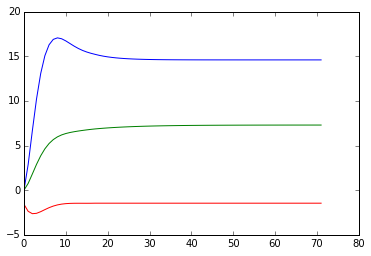

In [15]:
opt1,opt2 = prediction(extend(uopt))
plt.plot(opt1)
plt.plot(opt2)
plt.plot(extend(uopt))

Resample the discrete output to continuous time